In [ ]:
'''
This insatallation is done w.r.t missing librarys of Google Colab.
Differenct complier might need different installations.
'''
!pip install transformers 
!pip install pyvis
!pip install nltk

In [ ]:
#importing libraries
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import math
import torch
import IPython
from pyvis.network import Network
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [ ]:
# Load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("Babelscape/rebel-large")
model = AutoModelForSeq2SeqLM.from_pretrained("Babelscape/rebel-large")

In [ ]:
def extractRelationsFromModelOutput(txt):
    relations = []
    relation, subject, relation, obj = '', '', '', ''
    txt = txt.strip()
    current = 'x'
    txtReplaced = txt.replace("<s>", "").replace("<pad>", "").replace("</s>", "")
    for token in txtReplaced.split():
        if token == "<triplet>":
            current = 't'
            if relation != '':
                relations.append({
                    'head': subject.strip(),
                    'type': relation.strip(),
                    'tail': obj.strip()
                })
                relation = ''
            subject = ''
        elif token == "<subj>":
            current = 's'
            if relation != '':
                relations.append({
                    'head': subject.strip(),
                    'type': relation.strip(),
                    'tail': obj.strip()
                })
            obj = ''
        elif token == "<obj>":
            current = 'o'
            relation = ''
        else:
            if current == 't':
                subject += ' ' + token
            elif current == 's':
                obj += ' ' + token
            elif current == 'o':
                relation += ' ' + token
    if subject != '' and relation != '' and obj != '':
        relations.append({
            'head': subject.strip(),
            'type': relation.strip(),
            'tail': obj.strip()
        })
    return relations

In [ ]:
class KB():
    def __init__(self):
        self.relations = []

    def areRelationsEqual(self, r1, r2):
        return all(r1[attr] == r2[attr] for attr in ["head", "type", "tail"])

    def existsRelation(self, r1):
        return any(self.areRelationsEqual(r1, r2) for r2 in self.relations)

    def mergeRelations(self, r1):
        r2 = [r for r in self.relations
              if self.areRelationsEqual(r1, r)][0]
        spansToAdd = [span for span in r1["meta"]["spans"]
                        if span not in r2["meta"]["spans"]]
        r2["meta"]["spans"] += spansToAdd

    def add_relation(self, r):
        if not self.existsRelation(r):
            self.relations.append(r)
        else:
            self.mergeRelations(r)

    def print(self):
      return self.relations

In [ ]:
def textToKB(text, span_length=128, verbose=False):
    # tokenize whole text
    inputs = tokenizer([text], return_tensors="pt")

    # compute span boundaries
    num_tokens = len(inputs["input_ids"][0])
    if verbose:
        print(f"Input has {num_tokens} tokens")
    num_spans = math.ceil(num_tokens / span_length)
    if verbose:
        print(f"Input has {num_spans} spans")
    overlap = math.ceil((num_spans * span_length - num_tokens) / 
                        max(num_spans - 1, 1))
    spans_boundaries = []
    start = 0
    for i in range(num_spans):
        spans_boundaries.append([start + span_length * i,
                                 start + span_length * (i + 1)])
        start -= overlap
    if verbose:
        print(f"Span boundaries are {spans_boundaries}")

    # transform input with spans
    tensor_ids = [inputs["input_ids"][0][boundary[0]:boundary[1]]
                  for boundary in spans_boundaries]
    tensor_masks = [inputs["attention_mask"][0][boundary[0]:boundary[1]]
                    for boundary in spans_boundaries]
    inputs = {
        "input_ids": torch.stack(tensor_ids),
        "attention_mask": torch.stack(tensor_masks)
    }

    # generate relations
    num_return_sequences = 3
    gen_kwargs = {
        "max_length": 256,
        "length_penalty": 0,
        "num_beams": 3,
        "num_return_sequences": num_return_sequences
    }
    generated_tokens = model.generate(
        **inputs,
        **gen_kwargs,
    )

    # decode relations
    decoded_preds = tokenizer.batch_decode(generated_tokens,
                                           skip_special_tokens=False)

    # create kb
    kb = KB()
    i = 0
    for sentence_pred in decoded_preds:
        current_span_index = i // num_return_sequences
        relations = extractRelationsFromModelOutput(sentence_pred)
        for relation in relations:
            relation["meta"] = {
                "spans": [spans_boundaries[current_span_index]]
            }
            kb.add_relation(relation)
        i += 1

    return kb

In [ ]:
def featureAssignment(x):
  # extract subject
  head = [i['head'] for i in x]
  # extract object
  tail = [i['tail'] for i in x]
  #extract relations
  edge = [i['type'] for i in x]

  df = pd.DataFrame({'head':head, 'tail':tail, 'edge':edge})
  return df

In [ ]:
def plottingGraph(df):
  # create a directed-graph from a dataframe
  G=nx.from_pandas_edgelist(df, "head", "tail",
                            edge_attr=True, create_using=nx.MultiDiGraph())
  plt.figure(figsize=(12,12))
  pos = nx.spring_layout(G)
  m = { (df.iloc[i,0],df.iloc[i,1]):df.iloc[i,2] for i in range(len(df)) }
  nx.draw(G, with_labels=True, node_color='green', edge_cmap=plt.cm.Blues, pos = pos)
  nx.draw_networkx_edge_labels(G,pos, edge_labels=m)
  return plt

In [ ]:
def letters(input):
    valids = []
    input = input.split()
    for i in input:
      l =[]
      for j in i:
        if j.isalpha():
          l.append(j)
      l = "".join(i for i in l)
      valids.append(l)
    return valids

In [ ]:
def predLst(df):
  l =[]
  for i in df['head']:
    l.append(i)
  for i in df['tail']:
    l.append(i)
  for i in df['edge']:
    l.append(i)
  l = set(l)
  return(l)

In [ ]:
def score(pred,true):
  m = set()
  for i in pred :
    for j in true :
      if i.lower() == j.lower():
        m.add(i)
  return len(m)

In [ ]:
''' beta version , not in use 
def stopWords(s):
  import nltk
  nltk.download('stopwords')
  nltk.download('punkt')
  stop_words = set(stopwords.words('english'))
  word_tokens = word_tokenize(s)   
  filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]    
  filtered_sentence = []   
  for w in word_tokens:
      if w not in stop_words:
          filtered_sentence.append(w)
  return(filtered_sentence)
  '''

" beta version , not in use \ndef stopWords(s):\n  import nltk\n  nltk.download('stopwords')\n  nltk.download('punkt')\n  stop_words = set(stopwords.words('english'))\n  word_tokens = word_tokenize(s)   \n  filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]    \n  filtered_sentence = []   \n  for w in word_tokens:\n      if w not in stop_words:\n          filtered_sentence.append(w)\n  return(filtered_sentence)\n  "

Enter your text: 22-year-old college football player clipped on left side during play. Exam Exam revealed a grossly swollen and contused left knee associated with medial joint line tenderness, pain with valgus stress, and a positive Lachman test. Findings Anterior-posterior radiograph of the left knee reveals a 5mm elliptical ossific fragment adjacent and distal to the lateral tibial cortex and plateau, respectively, consistent with a Segond fracture. The lateral radiograph shows increased density in the region of the suprapatellar bursa consistent with a knee effusion. Proton-density with fat saturation sagittal oblique MR image of the left knee shows a complete tear of the anterior cruciate ligament (ACL) at its proximal attachment and increased signal intensity in the normal location of the ligament consistent with post-traumatic change. The fibers that lie parallel with the tibial plateau are consistent with the torn ACL. High-signal-intensity bone contusions are present in the mid

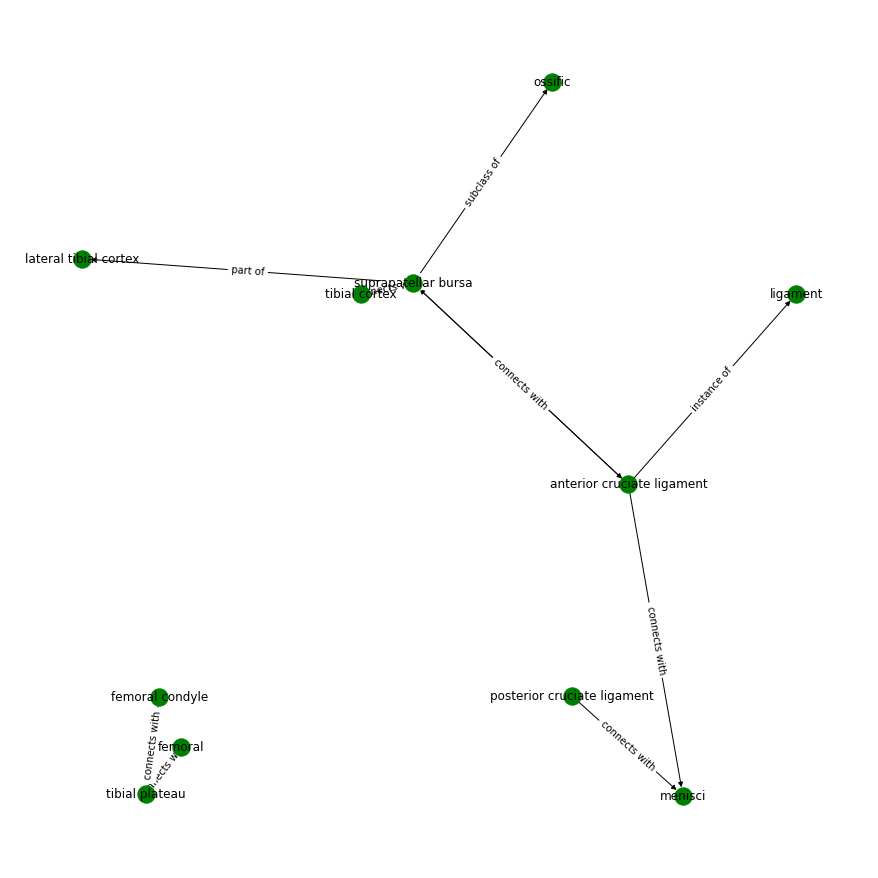

In [ ]:
text = input('Enter your text: ')
kb = textToKB(text, verbose=True)
x = kb.print()
print(x)
df = featureAssignment(x)
plot = plottingGraph(df)
plot.show()

In [ ]:
true = input('Enter actual output :')
true = letters(true)
pred = predLst(df)
pred = " ".join(pred)
pred = letters(pred)
lenTrue = len(true)
lenPred = len(pred)
match = score(pred,true)
print('There were',lenTrue,' words in required output out of which',match,'words were found in predicted output')


Enter actual output :ACL tear with associated Segond Fracture and Kissing Contusions
There were 9  words in required output out of which 1 words were found in predicted output
